## Задача 1

Реализовать класс для работы с линейной регрессией

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [2]:
class MyLinearRegression:
    """
    Parameters
    ----------
    regularization : {None, 'l1', 'l2', 'l1l2'}, default=None
        Какую регуляризацию добавить к модели. Если значение `None`, то без регуляризации.

    weight_calc : {'matrix', 'gd', 'sgd'}, default='matrix'
        Каким образом вычислять вектор весов: матрично ('matrix'), градиентным спуском ('gd') или стохастическим градиентным спуском ('sgd'). При этом, при 'l1' или 'l1l2' нельзя использовать параметр 'matrix'.

    Attributes
    ----------
    coefs_ : Вектор коэффициентов размера (p, 1), где p — количество признаков.
    intercept_ : Значение коэффициента, отвечающего за смещение
    """

    def __init__(self, regularization=None, weight_calc='matrix', lambda_1=None, lambda_2=None, batch_size=20, learning_rate=0.01, max_iter=1000, random_state=None, epsilon=1e-10):
        if regularization not in [None, 'l1', 'l2', 'l1l2']:
            raise TypeError(f"Параметр regularization не может принимать значение '{regularization}'")
        if weight_calc not in ['matrix', 'gd', 'sgd']:
            raise TypeError(f"Параметр weight_calc не может принимать значение '{weight_calc}'")
        if regularization in ['l1', 'l1l2'] and lambda_1 is None:
            raise TypeError(f"Значение коэффициента регуляризации l1 не задано")
        if regularization in ['l2', 'l1l2'] and lambda_2 is None:
            raise TypeError(f"Значение коэффициента регуляризации l2 не задано")

        self.regularization = regularization
        self.weight_calc = weight_calc
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state
        self.epsilon = epsilon

        self.coefs_ = None
        self.intercept_ = None

        if random_state is not None:
            np.random.seed(random_state)

    # Добавляем столбец из единиц к матрице Х для учета свободного члена в модели
    def _add_intercept(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        return np.hstack([np.ones((X.shape[0], 1)), X])

    # Аналитическое решение: Θ=(𝑋^𝑇𝑋)^−1𝑋^𝑇𝑌
    def _fit_matrix(self, X, y):
        X_bias = self._add_intercept(X)
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values.reshape(-1, 1)
        XtX = X_bias.T @ X_bias

        # L2 регуляризация
        if self.regularization == 'l2':
            reg = self.lambda_2 * np.eye(XtX.shape[0])
            reg[0, 0] = 0
            XtX = XtX + reg

        theta = np.linalg.inv(XtX) @ X_bias.T @ y
        self.intercept_ = theta[0, 0]
        self.coefs_ = theta[1:, 0]

    # Основной метод для обучения модели
    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        if self.weight_calc == 'matrix':
            if self.regularization in ['l1', 'l1l2']:
                raise ValueError("При 'l1' или 'l1l2' нельзя использовать параметр 'matrix'")
            self._fit_matrix(X, y)
        else:
            if isinstance(y, (pd.DataFrame, pd.Series)):
                y = y.values.reshape(-1, 1)

            X_bias = self._add_intercept(X)
            n_samples, n_features = X_bias.shape

            W = np.random.RandomState(self.random_state).uniform(size=(n_features, 1))

            for _ in range(self.max_iter):
                if self.weight_calc == 'gd':
                    y_pred = X_bias @ W
                    grad = (2 / n_samples) * X_bias.T @ (y_pred - y)
                else:  # sgd
                    idx = np.random.choice(n_samples, min(self.batch_size, n_samples), replace=False)
                    X_batch = X_bias[idx]
                    y_batch = y[idx]
                    y_pred = X_batch @ W
                    grad = (2 / len(idx)) * X_batch.T @ (y_pred - y_batch)

                # L2 регуляризация
                if self.regularization in ['l2', 'l1l2']:
                    reg = self.lambda_2 * W
                    reg[0, 0] = 0
                    grad += reg

                # L1 регуляризация
                if self.regularization in ['l1', 'l1l2']:
                    grad += self.lambda_1 * np.sign(W)
                    grad[0, 0] -= self.lambda_1 * np.sign(W[0, 0])

                W -= self.learning_rate * grad

                if np.linalg.norm(grad) < self.epsilon:
                    break

            self.intercept_ = W[0, 0]
            self.coefs_ = W[1:, 0]
        return self

    def predict(self, X: np.array):
        if isinstance(X, pd.DataFrame):
            X = X.values
        return X @ self.coefs_ + self.intercept_

    def score(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values.reshape(-1)
        y_pred = self.predict(X)
        return 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)


Используя датасет про автомобили (целевой признак — price), сравнить (качество, скорость обучения и предсказания, важность признаков) модели `MyLinearRegression` с различными гиперпараметрами, сделать выводы. На этом же датасете сравнить модель `MyLinearRegression` с библиотечной реализацией из `sklearn`, составить таблицу(ы) (графики) результатов сравнения (качество, скорость обучения и предсказания, важность признаков).

In [3]:
!gdown 1hp6FhDqUJ-aH3cAFxmVPnzuRdL2SYyFL

Downloading...
From: https://drive.google.com/uc?id=1hp6FhDqUJ-aH3cAFxmVPnzuRdL2SYyFL
To: /content/Used_fiat_500_in_Italy_dataset.csv
100% 27.2k/27.2k [00:00<00:00, 9.95MB/s]


In [4]:
# Импортируем данные
df = pd.read_csv('Used_fiat_500_in_Italy_dataset.csv')
df.head()

,model,engine_power,transmission,age_in_days,km,previous_owners,lat,lon,price
0,pop,69,manual,4474,56779,2,45.071079,7.46403,4490
1,lounge,69,manual,2708,160000,1,45.069679,7.70492,4500
2,lounge,69,automatic,3470,170000,2,45.514599,9.28434,4500
3,sport,69,manual,3288,132000,2,41.903221,12.49565,4700
4,sport,69,manual,3712,124490,2,45.532661,9.03892,4790


In [5]:
# Проверим, есть ли пропуски
df.isna().sum()

,0
model,0
engine_power,0
transmission,0
age_in_days,0
km,0
previous_owners,0
lat,0
lon,0
price,0


In [6]:
# Посмотрим типы данных
df.dtypes

,0
model,object
engine_power,int64
transmission,object
age_in_days,int64
km,int64
previous_owners,int64
lat,float64
lon,float64
price,int64


In [7]:
# Преобразуем категориальные переменные model и transmission
df = pd.get_dummies(df, columns=['model', 'transmission'], drop_first=True)

In [8]:
# Разделяем данные на обучающую и тестовую выборки
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Масштабируем числовые признаки
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# Создаем функцию для обучения и оценки модели
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Время обучения
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    # Время предсказания
    start = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - start

    # Качество (r^2)
    r2_test = r2_score(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)

    return {
        'r2_test': r2_test,
        'mae_test': mae_test,
        'train_time': train_time,
        'predict_time': pred_time}

In [11]:
configs = [
    # Без регуляризации
    {'weight_calc': 'matrix', 'regularization': None},
    {'weight_calc': 'gd', 'regularization': None},
    {'weight_calc': 'sgd', 'regularization': None},

    # L2 регуляризация
    {'weight_calc': 'matrix', 'regularization': 'l2', 'lambda_2': 1.0},
    {'weight_calc': 'gd', 'regularization': 'l2', 'lambda_2': 1.0, 'learning_rate':0.01, 'max_iter':2000},
    {'weight_calc': 'sgd', 'regularization': 'l2', 'lambda_2': 1.0, 'learning_rate':0.01, 'max_iter':2000},

    # L1 регуляризация
    {'weight_calc': 'gd', 'regularization': 'l1', 'lambda_1': 0.1, 'learning_rate':0.01, 'max_iter':3000},
    {'weight_calc': 'sgd', 'regularization': 'l1', 'lambda_1': 0.1, 'learning_rate':0.01, 'max_iter':3000},

    # L1+L2 регуляризация
    {'weight_calc': 'gd', 'regularization': 'l1l2', 'lambda_1': 0.1, 'lambda_2': 1.0, 'learning_rate':0.01, 'max_iter':3000},
    {'weight_calc': 'sgd', 'regularization': 'l1l2', 'lambda_1': 0.1, 'lambda_2': 1.0, 'learning_rate':0.01, 'max_iter':3000},]

In [12]:
# Сосбственная реализация
results = []

for cfg in configs:
    # Создаем модель с нужными параметрами
    model = MyLinearRegression(
        weight_calc=cfg.get('weight_calc', 'matrix'),
        regularization=cfg.get('regularization', None),
        lambda_1=cfg.get('lambda_1', None),
        lambda_2=cfg.get('lambda_2', None),
        learning_rate=cfg.get('learning_rate', 0.01),
        max_iter=cfg.get('max_iter', 1000),
        random_state=42)

    # Оцениваем модель
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)

    # Сохраняем результаты
    results.append({
        'model': 'MyLinearRegression',
        'regularization': cfg.get('regularization', 'None'),
        'weight_calc': cfg.get('weight_calc', 'matrix'),
        **metrics})

results_df = pd.DataFrame(results)
results_df

,model,regularization,weight_calc,r2_test,mae_test,train_time,predict_time
0,MyLinearRegression,None,matrix,0.894534,559.224390,0.007631,0.000029
1,MyLinearRegression,None,gd,0.894410,559.499515,0.015512,0.000015
2,MyLinearRegression,None,sgd,0.894120,562.980839,0.043036,0.000013
3,MyLinearRegression,l2,matrix,0.894395,559.198365,0.000179,0.000007
4,MyLinearRegression,l2,gd,0.829595,693.744164,0.032614,0.000012
5,MyLinearRegression,l2,sgd,0.809726,722.123441,0.097729,0.000012
6,MyLinearRegression,l1,gd,0.894523,559.241026,0.077462,0.000016
7,MyLinearRegression,l1,sgd,0.900231,536.997978,0.165797,0.000012
8,MyLinearRegression,l1l2,gd,0.829584,693.757858,0.042701,0.000011
9,MyLinearRegression,l1l2,sgd,0.831511,696.313147,0.191402,0.000018


**Вывод:**

Анализируя результаты, полученные с собственной реализацией, можно отметить, что:

1. Без регуляризации все три метода (matrix, gd, sgd) обеспечивают примерно одинаковое качество моделей ($r^2$). При этом аналитическое решение обеспечивает наиболее быстро время обучения.
2. При использовании L2-регуляризации отмечается заметное ухудшение качества модели в сочетании с gd и sgd, MAE также значительно увеличилась, при параметрах sgd и L2 MAE достигает наибольшее значение среди рассматриваемых моделей. Такой эффект может быть связан с большим значением $λ_2$, в результате чего модель недообучилась.Наилучшее значения по качеству и времени достигаются при аналитическом решении.
3. L1-регуляризация в сочетании с sgd оказалась наиболее эффективной для данного датасета (максимальное значение $r^2$ и минимальное MAE).
4. При использовании комбинации L1L2 модели демонстрируют худшее качество в сравнении с моделями с L1-регуляризацией и без регуляризации, что может быть связано с слишком большой суммарной регуляризацией.

In [13]:
# Вывод коэффициентов для каждой модели
for cfg in configs:
    model = MyLinearRegression(regularization=None, weight_calc=cfg['weight_calc'], learning_rate=0.01, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    # Таблица коэффициентов
    coef_df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coefs_}).sort_values(by='coefficient', ascending=False)

    print(f"\n Коэффициенты для weight_calc = {cfg['weight_calc']}")
    print("Intercept:", model.intercept_)
    print(coef_df)


 Коэффициенты для weight_calc = matrix
Intercept: 5797.64144736842
               feature  coefficient
5                  lon   252.261034
4                  lat   194.473519
7          model_sport    54.641213
3      previous_owners    50.413363
6            model_pop    46.634749
0         engine_power    39.824028
8           model_star    35.700712
9  transmission_manual    -3.124951
2                   km  -556.685210
1          age_in_days -1533.837809

 Коэффициенты для weight_calc = gd
Intercept: 5797.641437611811
               feature  coefficient
5                  lon   250.529995
4                  lat   192.659282
7          model_sport    54.404371
3      previous_owners    50.498227
6            model_pop    46.388686
0         engine_power    39.804413
8           model_star    35.841448
9  transmission_manual    -3.300563
2                   km  -558.592661
1          age_in_days -1531.711781

 Коэффициенты для weight_calc = sgd
Intercept: 5788.6342543041865
        

**Вывод:**

Анализируя полученные результаты, можно отметить, что наибольшее влияние на стоимость автомобиля оказывают параметры age_in_days и km, при этом они имеют отрицательное влияние. То есть, чем "старше" автомобиль и больше пробег, тем цена будет существенно ниже.

Также существенное положительное влияние на стоимость автомобиля оказывают lon и lat.

In [ ]:
# Библиотечная реализация
results_sklearn = []

models = [
    ('LinearRegression', LinearRegression()),
    ('Ridge', Ridge(alpha=1.0)),
    ('Lasso', Lasso(alpha=0.1, max_iter=5000)),
    ('ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000))]

for name, model in models:
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)

    results_sklearn.append({
        'model': name,
        'regularization': name,
        'weight_calc': 'library',
        **metrics})

results_sklearn_df = pd.DataFrame(results_sklearn)
results_sklearn_df

,model,regularization,weight_calc,r2_test,mae_test,train_time,predict_time
0,LinearRegression,LinearRegression,library,0.894534,559.224390,0.002091,0.000317
1,Ridge,Ridge,library,0.894395,559.198365,0.001829,0.000262
2,Lasso,Lasso,library,0.894512,559.258013,0.001751,0.000278
3,ElasticNet,ElasticNet,library,0.891348,564.670778,0.002041,0.000272


**Вывод:**

Анализируя результаты, полученные с применением библиотечной реализацией линейной регрессии, можно отметить, что все модели обучаются достаточно быстро и демонстрируют высокое качество ($r_2$). Модели LinearRegression и Ridge показывают результаты, которые совпадают с аналитическим решением в собственной реализации. Модель ElasticNet также демонстрирует наибольшее значение MAE, что указывает на худшее качество предсказаний по сравнению с остальными методами.

In [ ]:
# Вывод коэффициентов для моделей sklearn
for name, model in models:
    model.fit(X_train, y_train)  \

    # Таблица коэффициентов
    coef_df = pd.DataFrame({
        'feature': X.columns,
        'coefficient': model.coef_}).sort_values(by='coefficient', ascending=False)

    print(f"\nКоэффициенты для {name}")
    print("Intercept:", model.intercept_)
    print(coef_df)


Коэффициенты для LinearRegression
Intercept: 5797.641447368421
               feature  coefficient
5                  lon   252.261034
4                  lat   194.473519
7          model_sport    54.641213
3      previous_owners    50.413363
6            model_pop    46.634749
0         engine_power    39.824028
8           model_star    35.700712
9  transmission_manual    -3.124951
2                   km  -556.685210
1          age_in_days -1533.837809

Коэффициенты для Ridge
Intercept: 5797.641447368421
               feature  coefficient
5                  lon   248.933054
4                  lat   191.301436
7          model_sport    53.442064
3      previous_owners    50.401081
6            model_pop    45.398972
0         engine_power    38.753306
8           model_star    36.256041
9  transmission_manual    -3.415722
2                   km  -560.162155
1          age_in_days -1525.523204

Коэффициенты для Lasso
Intercept: 5797.641447368421
               feature  coefficient
5 

**Вывод:**

Можно отметить, что общая структура влияния признаков совпадает со смыслом, который мы получили для собственной реализации.

Если посмотреть на коэффициенты, полученные для Ridge, то можно заметить, что они немного уменьшены по сравнению с LinearRegression, что связано с тем, что L2 регуляризация "штрафует" за большие значения коэффициентов с целью снижения коэффициентов. При L1 регуляризации коэффициенты почти не поменялись, так как $α = 0.1$ (не очень большое значение). Значительные изменения коэффициентов мы наблюдаем при L1L2 регуляризации, коэффициенты заметно стали меньше.

In [ ]:
# Объединяем все результаты и выводим итоговую таблицу
all_results = pd.concat([results_df, results_sklearn_df], ignore_index=True)

all_results[['model', 'regularization', 'weight_calc', 'r2_test', 'mae_test', 'train_time', 'predict_time']]


,model,regularization,weight_calc,r2_test,mae_test,train_time,predict_time
0,MyLinearRegression,None,matrix,0.894534,559.224390,0.001596,0.000071
1,MyLinearRegression,None,gd,0.894410,559.499515,0.029892,0.000018
2,MyLinearRegression,None,sgd,0.894120,562.980839,0.048447,0.000017
3,MyLinearRegression,l2,matrix,0.894395,559.198365,0.000321,0.000010
4,MyLinearRegression,l2,gd,0.829595,693.744164,0.040618,0.000020
5,MyLinearRegression,l2,sgd,0.809726,722.123441,0.095573,0.000016
6,MyLinearRegression,l1,gd,0.894523,559.241026,0.058770,0.000019
7,MyLinearRegression,l1,sgd,0.900231,536.997978,0.170985,0.000020
8,MyLinearRegression,l1l2,gd,0.829584,693.757858,0.043935,0.000016
9,MyLinearRegression,l1l2,sgd,0.831511,696.313147,0.156103,0.000022


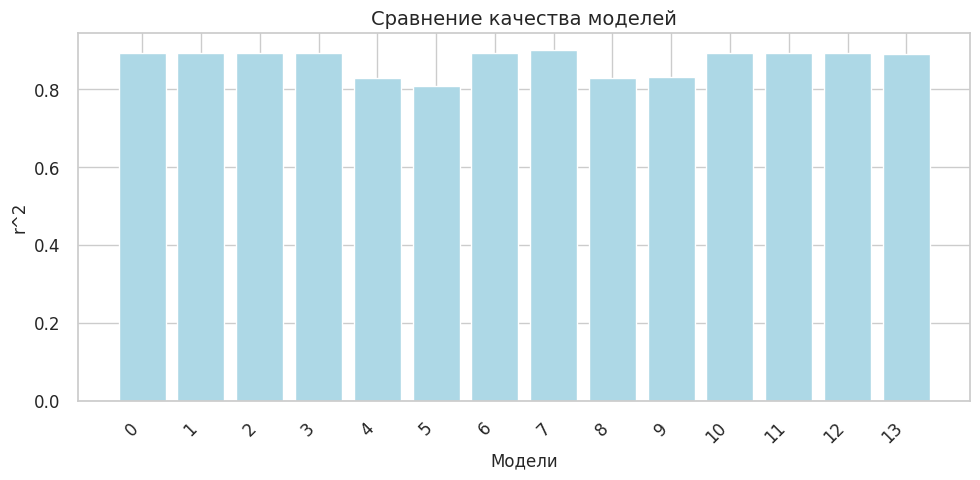

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(all_results.index.astype(str), all_results['r2_test'], color='lightblue')

plt.title('Сравнение качества моделей', fontsize=14)
plt.xlabel('Модели', fontsize=12)
plt.ylabel('r^2', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Находим модель с максимальным r^2
best_r2_model = all_results.loc[all_results['r2_test'].idxmax()]
best_r2_model

,7
model,MyLinearRegression
regularization,l1
weight_calc,sgd
r2_test,0.900231
mae_test,536.997978
train_time,0.170985
predict_time,0.00002


In [ ]:
# Находим модель с минимальным MAE
best_mae_model = all_results.loc[all_results['mae_test'].idxmin()]
best_mae_model

,7
model,MyLinearRegression
regularization,l1
weight_calc,sgd
r2_test,0.900231
mae_test,536.997978
train_time,0.170985
predict_time,0.00002


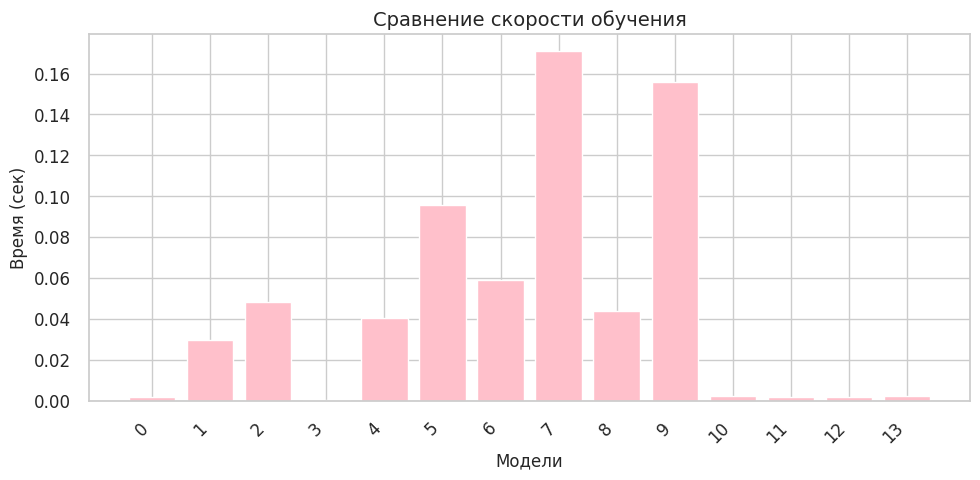

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(all_results.index.astype(str), all_results['train_time'], color='pink')

plt.title('Сравнение скорости обучения', fontsize=14)
plt.xlabel('Модели', fontsize=12)
plt.ylabel('Время (сек)', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Находим модель с минимальным временем обучения
best_time_model = all_results.loc[all_results['train_time'].idxmin()]
best_time_model

,3
model,MyLinearRegression
regularization,l2
weight_calc,matrix
r2_test,0.894395
mae_test,559.198365
train_time,0.000321
predict_time,0.00001


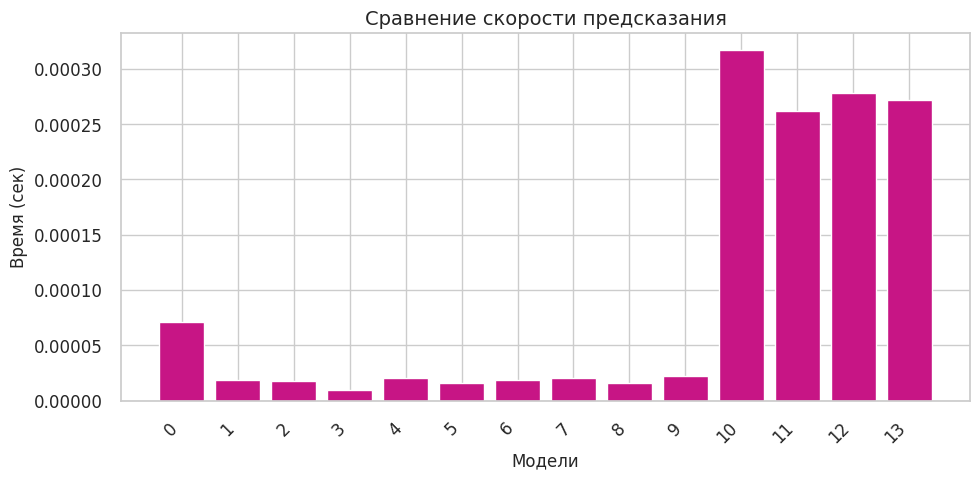

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(all_results.index.astype(str), all_results['predict_time'], color='mediumvioletred')

plt.title('Сравнение скорости предсказания', fontsize=14)
plt.xlabel('Модели', fontsize=12)
plt.ylabel('Время (сек)', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Находим модель с минимальным временем предсказания
best_predict_model = all_results.loc[all_results['predict_time'].idxmin()]
best_predict_model

,3
model,MyLinearRegression
regularization,l2
weight_calc,matrix
r2_test,0.894395
mae_test,559.198365
train_time,0.000321
predict_time,0.00001


### **Вывод**

Таким образом, на данном датасете лучшей по качеству предсказаний оказалась модель MyLinearRegression с L1-регуляризацией и SGD, демонстрируя максимальное значение $r_2$ и минимальное MAE. При этом модель с аналитческим решением и библиотечная LinearRegression показывает сопоставимое качество, значительно меньшее время обучения. Модели с L2 и L1+L2 регуляризацией уступают по точности, что связано с недообучением при выбранных параметрах λ.

## Задача 2

[Соревнование на Kaggle](https://kaggle.com/competitions/yadro-regression-2025)